 # Analiza podnebnih podatkov

 ## 1. Uvod

 Ta projekt vsebuje celovito rešitev za pridobivanje in analizo podnebnih podatkov za različna mesta po svetu. Sestavljen je iz treh glavnih delov:



 1. **Pridobivanje podatkov**: Skripti za pridobivanje podatkov iz Meteostat API

 2. **Analiza podatkov**: Obdelava in statistična analiza

 3. **Vizualizacija**: Grafični prikaz rezultatov

 ## 2. Nastavitev okolja

 ### 2.1 Uvoz potrebnih knjižnic

-  Pri pogonu se avtomatsko naložijo vse potrebne knjižnice,
   potreben pa je ponovni zagon notebooka (Restart  => Run All)

In [1]:
import os                               # Operacijski sistem
from datetime import datetime           # Datumi
import pandas as pd                     # Pandas
from meteostat import Point, Daily      # Geografska lokacija in dnevni podatki
from tqdm import tqdm                   # Progress bar
import numpy as np                      # Numerično
from scipy import stats                 # Statistika
from pathlib import Path                # Poti do datotek
import glob                             # Iskanje datotek
import matplotlib.pyplot as plt         # Grafi
import seaborn as sns                   # Statistične vizualizacije

from zahteve_namestitev import instalacija
instalacija()

True

 ### 2.2 Spremenljivke in poti

-  Nastavimo osnovne poti in potrebne mape

-  Naprintamo spravljene spremenljivke

In [2]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "Podatki" / "ne_predelani"
RESULTS_DIR = BASE_DIR / "Podatki" / "rezultati"

DATA_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f" Osnovni imenik projekta: {BASE_DIR}")
print(f" Mapa za podatke: {DATA_DIR}")
print(f" Mapa za rezultate: {RESULTS_DIR}")


 Osnovni imenik projekta: c:\Users\Uporabnik\Projektna_naloga_UVP
 Mapa za podatke: c:\Users\Uporabnik\Projektna_naloga_UVP\Podatki\ne_predelani
 Mapa za rezultate: c:\Users\Uporabnik\Projektna_naloga_UVP\Podatki\rezultati


 ## 3. Pridobivanje podatkov

 ### 3.1 Pomožne skripte za pridobivanje podatkov

-  `ustvari_mapo()`

-  `shrani_podatke()` - za posamezno lokacijo in leto v CSV formatu

In [3]:
def ustvari_mapo(pot):

    os.makedirs(pot, exist_ok=True)

def shrani_podatke(df, lokacija_ime, leto):

    pot = DATA_DIR / lokacija_ime
    ustvari_mapo(pot)
    datoteka = pot / f"{lokacija_ime}_{leto}_temperature.csv"
    df.to_csv(datoteka, index=False)

 ### 3.2 Definiramo izbrane lokacije

In [4]:
lokacije = [
    {'ime': 'Ljubljana', 'lat': 46.05, 'lon': 14.51, 'klimatski_pas': 'Zmerni'},
    {'ime': 'Reykjavik', 'lat': 64.13, 'lon': -21.82, 'klimatski_pas': 'Polarni'},
    {'ime': 'Singapore', 'lat': 1.35, 'lon': 103.86, 'klimatski_pas': 'Tropski'},
    {'ime': 'Sydney', 'lat': -33.87, 'lon': 151.21, 'klimatski_pas': 'Subtropski'},
    {'ime': 'Tokyo', 'lat': 35.68, 'lon': 139.77, 'klimatski_pas': 'Zmerni'},
    {'ime': 'Barrow', 'lat': 71.29, 'lon': -156.79, 'klimatski_pas': 'Polarni'},
    {'ime': 'Cairo', 'lat': 30.04, 'lon': 31.24, 'klimatski_pas': 'Subtropski'},
    {'ime': 'Buenos_Aires', 'lat': -34.60, 'lon': -58.38, 'klimatski_pas': 'Subtropski'},
    {'ime': 'Cape_Town', 'lat': -33.92, 'lon': 18.42, 'klimatski_pas': 'Subtropski'},
    {'ime': 'Mumbai', 'lat': 19.08, 'lon': 72.88, 'klimatski_pas': 'Tropski'}
]


 ### 3.3 Pridobivanje podatkov

Nastavimo parametre, začetni in končni datum in definiramo funkcijo:

-  Funkcija `pridobi_podatke_za_lokacije` Pridobi podatke za vse definirane
   lokacije v določenem časovnem obdobju.

-  Zbiranje podatkov znotraj zanke (`for`) se kaže preko progress bara

-  `Try` zajema morebitne napake, v spremenljivko `tocka` se ustvari geografska

    lokacija iz zempljepisne širine (`lon`) in dolžine (`lat`)

-  `Daily()` - template za dnevne podatke

-  `fetch()` pošlje zahtevo k Meteostat API in podatke dobi v obliki `df`
    (DataFrame)

 ###  3.4  Obdelava podatkov


-   Funkcija `reset_index()` ponastavi indeks df.

-   Ustvari stolpec `temperatura_avg`

-  `dt.year.unique()` poišče unikatna leta v podatkih

-   Funkcija `shrani_podatke()` za vsako leto

 ###  3.5  Napake

-  Izpiše ime lokacije in opis napake

-  Klic funkcije `pridobi_podatke_za_lokacije()` shrani rezultate v
   spremenljivki `uspeh` in `neuspeh`

In [5]:
zacetek = datetime(1950, 1, 1)
konec = datetime(2023, 12, 31)
from meteostat_podatki import shrani_podatke

def pridobi_podatke_za_lokacije(lokacije, zacetek, konec):

    uspeh = 0
    neuspeh = 0

    for lokacija in tqdm(lokacije, desc="Pridobivanje podatkov"):
        try:
            tocka = Point(lokacija['lat'], lokacija['lon'])
            podatki = Daily(tocka, zacetek, konec)
            df = podatki.fetch()
            
            if df.empty:
                neuspeh += 1   #Preveri DataFrame
                continue
            
            
            df = df.reset_index()
            df['temperatura_avg'] = df['tavg']
            df = df[['time', 'temperatura_avg']]
            
            for leto in df['time'].dt.year.unique():
                df_leto = df[df['time'].dt.year == leto]
                shrani_podatke(df_leto, lokacija['ime'], leto)
            
            uspeh += 1

        except Exception as e:
            print(f"Napaka pri {lokacija['ime']}: {str(e)}")
            neuspeh += 1
    
    return uspeh, neuspeh

uspeh, neuspeh = pridobi_podatke_za_lokacije(lokacije, zacetek, konec)

print(f"\n Uspešno: {uspeh} lokacij")
print(f" Neuspešno: {neuspeh} lokacij")
print(" Pridobivanje podatkov končano!")
print(f" Mapa za podatke: {DATA_DIR}")


Pridobivanje podatkov: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


 Uspešno: 10 lokacij
 Neuspešno: 0 lokacij
 Pridobivanje podatkov končano!
 Mapa za podatke: c:\Users\Uporabnik\Projektna_naloga_UVP\Podatki\ne_predelani


 ## 4. Analiza podatkov

 ### 4.1 Nalaganje in predobdelava podatkov

Funkcija `nalozi_podatke_mesta` naloži in združi podatke

 -  `os.path.join()` - vzorec za iskanje datotek po imenu mesta

 -  `glob.glob()` - poišče ustrezne datoteke

 -  `vsi_podatki` - pripravljen prazen seznam za shranjevanje df

 -  for `datoteka` in `tqdm`() - progress bar

 -  `pd.read_csv()` - prebere CSV in pretvori time v datetime object

 -  `df.rename()` - spremeni ime stolpca (time => datum)

 -  `df.dropna()` - odstrani pomankljive vrstice

 -  `df[]` - doda stolpec z letom, mesecem in mestom

 -  `pd.concoat()` - združi DataFrame in jih uredu po datumu


In [6]:
def nalozi_podatke_mesta(pot, ime_mesta):
    """
    Naloži podatke za posamezno mesto
    """
    vzorec = os.path.join(pot, f"{ime_mesta}_*_temperature.csv")
    vse_datoteke = glob.glob(vzorec)

    if not vse_datoteke:
        raise FileNotFoundError(f"Ni datotek za: {ime_mesta} v {pot}")
        
    vsi_podatki = []
    
    for datoteka in sorted(vse_datoteke):
        try:
            df = pd.read_csv(datoteka, parse_dates=['time'])
            df = df.rename(columns={'time': 'datum'})
            df = df.dropna(subset=['temperatura_avg'])
            
            df['leto'] = df['datum'].dt.year
            df['mesec'] = df['datum'].dt.month
            df['mesto'] = ime_mesta
            
            vsi_podatki.append(df[['mesto', 'datum', 'leto', 'mesec', 'temperatura_avg']])
        except Exception as e:
            print(f"Napaka pri branju {os.path.basename(datoteka)}: {e}")
    
    if not vsi_podatki:
        raise ValueError(f"Ni veljavnih podatkov za {ime_mesta}")
    
    return pd.concat(vsi_podatki).sort_values('datum')


 ### 4.2 Statistična analiza

In [ ]:
def procesiraj_rezultate(df):
    """
    Izvede statistično analizo podatkov
    """
    rezultati = []
    mesta = df.groupby('mesto')
    
    print("\n🔍 Analiziram podatke:")
    for ime, group in mesta:
        print(f"  ⏳ Obdelujem {ime}...", end=" ")
        
        # Letne statistike
        letna = group.groupby('leto')['temperatura_avg'].agg(['mean', 'max', 'min']).reset_index()
        
        # Linearni trend
        slope, _, _, p_value, _ = stats.linregress(letna['leto'], letna['mean'])
        
        # Sezonska amplituda
        mesečna = group.groupby('mesec')['temperatura_avg'].mean()
        amplituda = mesečna.max() - mesečna.min()
        
        rezultati.append({
            'mesto': ime,
            'klimatski_pas': group['klimatski_pas'].iloc[0],
            'lat': group['lat'].iloc[0],
            'povprecna_temp': round(letna['mean'].mean(), 2),
            'trend_na_decade': round(slope * 10, 3),
            'p_value': round(p_value, 4),
            'sezonska_amplituda': round(amplituda, 2)
        })
        
    
    return pd.DataFrame(rezultati).sort_values('trend_na_decade', ascending=False)

 ### 4.3 Zagon celotne analize

In [ ]:
print(" Analizo podatkov ")

try:
    vsi_podatki = []
    
    # Nalaganje podatkov s statusnimi sporočili
    print(" Nalaganje podatkov za mesta:")
    for mesto in lokacije:
        ime = mesto['ime']
        pot_mesto = DATA_DIR / ime
        
        if not pot_mesto.exists():
            print(f"  {ime}: mapa ne obstaja")
            continue
            
        try:
            print(f"  {ime}: nalaganje...", end=" ")
            df = nalozi_podatke_mesta(pot_mesto, ime)
            df['lat'] = mesto['lat']
            df['klimatski_pas'] = mesto['klimatski_pas']
            vsi_podatki.append(df)
            print(" Uspešno")
        except Exception as e:
            print(f" Napaka: {str(e)}")
    
    if not vsi_podatki:
        raise ValueError("Ni podatkov za analizo")
    
    # Procesiranje z enim progress barjem
    rezultati = procesiraj_rezultate(pd.concat(vsi_podatki))
    
    # Shranjevanje rezultatov
    pot_rezultatov = RESULTS_DIR / "povzetek_analize.csv"
    rezultati.to_csv(pot_rezultatov, index=False, encoding='utf-8-sig')
    print(f"\n Rezultati shranjeni v: {pot_rezultatov}")
    
    # Prikaz rezultatov
    print("\n Povzetek rezultatov:")
    display(rezultati[['mesto', 'klimatski_pas', 'povprecna_temp', 'trend_na_decade', 'sezonska_amplituda']])
    
except Exception as e:
    print(f"Kritična napaka: {e}")

 Začenjam analizo podatkov...
 Nalaganje podatkov za mesta:
  Ljubljana: nalaganje...  Uspešno
  Reykjavik: nalaganje...  Uspešno
  Singapore: nalaganje...  Uspešno
  Sydney: nalaganje...  Uspešno
  Tokyo: nalaganje...  Uspešno
  Barrow: nalaganje...  Uspešno
  Cairo: nalaganje...  Uspešno
  Buenos_Aires: nalaganje...  Uspešno
  Cape_Town: nalaganje...  Uspešno
  Mumbai: nalaganje...  Uspešno

🔍 Analiziram podatke:
  ⏳ Obdelujem Barrow... ✅
  ⏳ Obdelujem Buenos_Aires... ✅
  ⏳ Obdelujem Cairo... ✅
  ⏳ Obdelujem Cape_Town... ✅
  ⏳ Obdelujem Ljubljana... ✅
  ⏳ Obdelujem Mumbai... ✅
  ⏳ Obdelujem Reykjavik... ✅
  ⏳ Obdelujem Singapore... ✅
  ⏳ Obdelujem Sydney... ✅
  ⏳ Obdelujem Tokyo... ✅

 Rezultati shranjeni v: c:\Users\Uporabnik\Projektna_naloga_UVP\Podatki\rezultati\povzetek_analize.csv

 Povzetek rezultatov:


,mesto,klimatski_pas,povprecna_temp,trend_na_decade,sezonska_amplituda
4,Ljubljana,Zmerni,11.52,0.644,20.92
0,Barrow,Polarni,-10.94,0.571,30.55
5,Mumbai,Tropski,27.33,0.391,6.31
2,Cairo,Subtropski,22.11,0.376,14.78
7,Singapore,Tropski,27.54,0.333,1.83
9,Tokyo,Zmerni,16.03,0.236,21.76
8,Sydney,Subtropski,17.97,0.212,10.31
6,Reykjavik,Polarni,4.88,0.177,11.28
1,Buenos_Aires,Subtropski,17.98,0.064,13.34
3,Cape_Town,Subtropski,16.84,0.045,8.76


 ## 5. Vizualizacija rezultatov

 ### 5.2 Trendi segrevanja po mestih

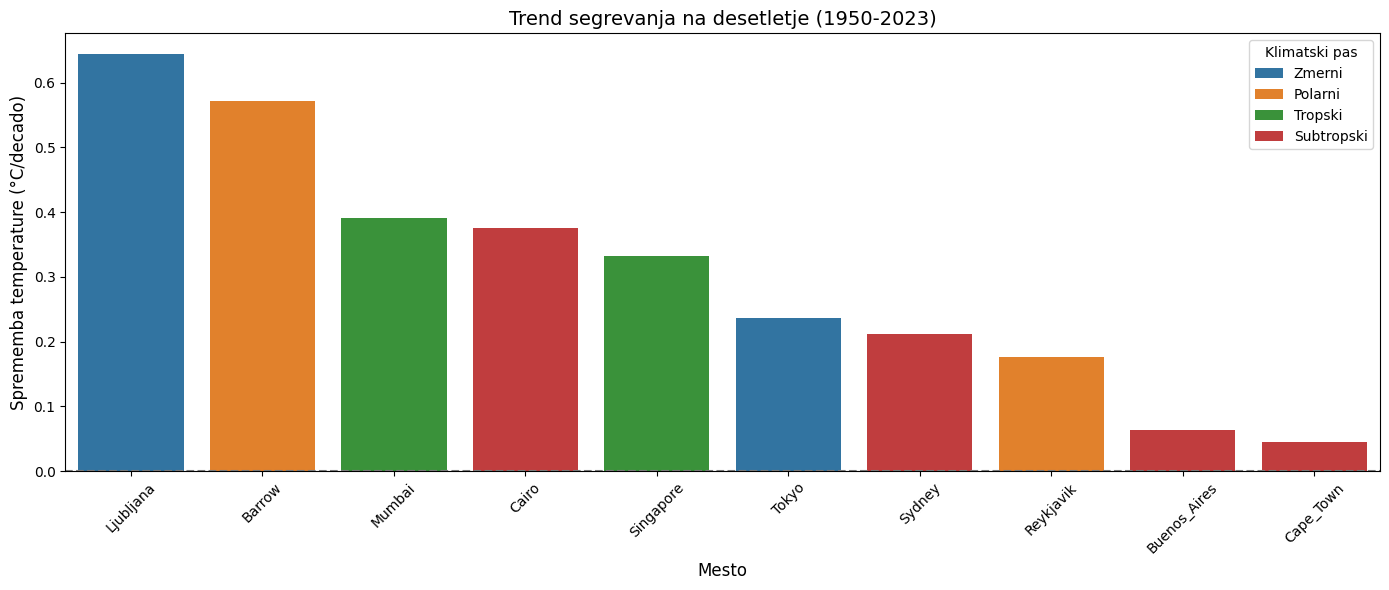

In [9]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=rezultati, x='mesto', y='trend_na_decade', hue='klimatski_pas')
plt.title('Trend segrevanja na desetletje (1950-2023)', fontsize=14)
plt.ylabel('Sprememba temperature (°C/decado)', fontsize=12)
plt.xlabel('Mesto', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Klimatski pas')
plt.tight_layout()
plt.show()


 ### 5.3 Odvisnost trendov od geografske širine

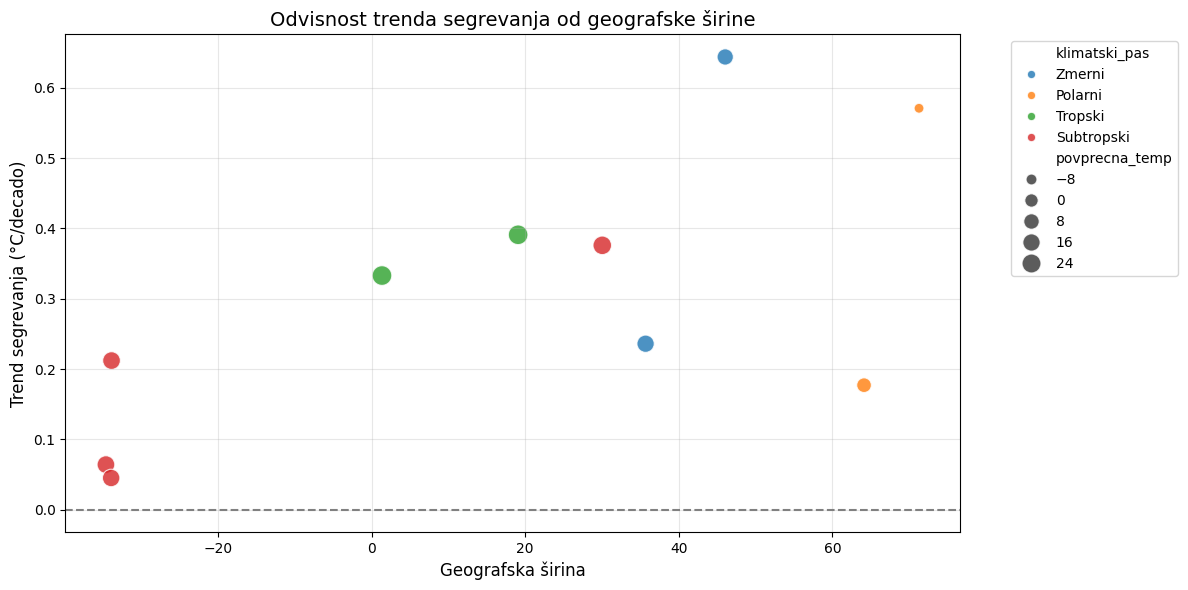

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rezultati, x='lat', y='trend_na_decade',
                hue='klimatski_pas', size='povprecna_temp',
                sizes=(50, 200), alpha=0.8)
plt.title('Odvisnost trenda segrevanja od geografske širine', fontsize=14)
plt.xlabel('Geografska širina', fontsize=12)
plt.ylabel('Trend segrevanja (°C/decado)', fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


 ## 6. Interpretacija rezultatov

 ### 6.1 Ključne ugotovitve

 ### 6.2 Zaključek

 ## 7. Tehnične specifikacije

 ## 8. Dodatni materiali / viri

 - [Dokumentacija Meteostat API](https://dev.meteostat.net/)

 - [Tehnike analize klimatskih podatkov](https://climatedataguide.ucar.edu/climate-tools)
